<a href="https://colab.research.google.com/github/0jg/DDPM-Toy-Example/blob/main/ddpm_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DDPM Diffusion Models: A Toy Example with Two Clusters

This notebook demonstrates the core mathematics and implementation of Denoising Diffusion Probabilistic Models (DDPM) using a simple 2D dataset with two clusters of points. This toy problem lets us visualise exactly what's happening at each step of the diffusion process.

## What We'll Cover

We'll implement the forward diffusion process that gradually adds noise to our data, then train a neural network to reverse this process. The key insight is that learning to denoise is easier than learning to generate from scratch, and by chaining many small denoising steps together, we can transform pure noise into realistic samples from our data distribution.

In [ ]:
import numpy as np
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting utils
# --- Set Built-in STIX Font ---
plt.rcParams.update({
    # Use the 'serif' font family
    'font.family': 'serif',
    # Matplotlib's built-in STIXGeneral font is used for the serif choice
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    # Ensure mathematical text matches the serif style
    'mathtext.fontset': 'stix',
    'font.size': 12, # Good size for readability
    'figure.dpi': 150
})

Using device: cuda


## Step 1: Create Our Toy Dataset

We'll create a simple dataset with two clusters of 2D points. This gives us a clear target distribution that's easy to visualise throughout the diffusion process.

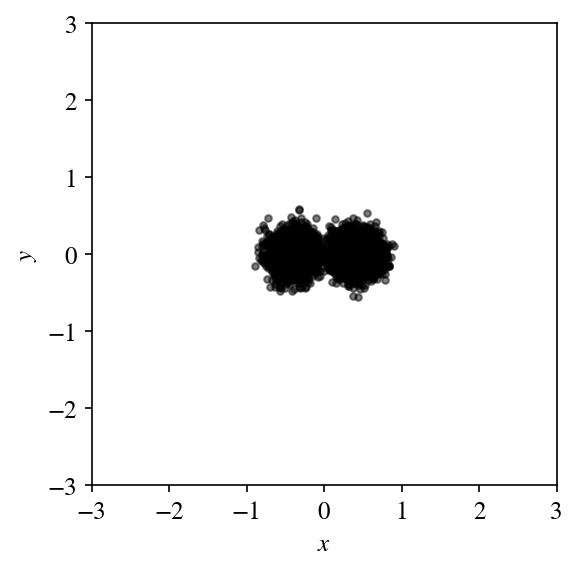

Dataset shape: (5000, 2)
Data range: [-0.886, 0.907]


In [ ]:
def create_two_cluster_dataset(n_samples=1000):
    """
    Create a dataset with two Gaussian clusters.

    This represents our target data distribution - what we want to learn to generate.
    Each cluster is a 2D Gaussian, and we'll sample roughly equal numbers from each.
    """
    cluster1 = np.random.randn(n_samples // 2, 2) * 0.15 + np.array([-0.4, 0])
    cluster2 = np.random.randn(n_samples // 2, 2) * 0.15 + np.array([0.4, 0])

    # Combine the clusters
    data = np.vstack([cluster1, cluster2])

    # Shuffle the data
    np.random.shuffle(data)

    return data.astype(np.float32)

# Generate our dataset
data = create_two_cluster_dataset(n_samples=5_000)

# Visualise the original data
plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10, color='k')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

print(f"Dataset shape: {data.shape}")
print(f"Data range: [{data.min():.3f}, {data.max():.3f}]")

## Step 2: Define the Forward Diffusion Process

The forward process gradually adds Gaussian noise to our data over T *algorithmic* timesteps. At each timestep t, we have a noise schedule parameter $\beta_t$ that controls how much noise to add. The key properties are:

- We can compute the noisy version at any timestep $t$ directly from the original data $x_0$, without having to step through all previous timesteps (see the 'reparameterisation trick')
- At timestep $t=T$, the data should be essentially pure Gaussian noise
- The noise schedule $\beta_t$ is typically small and increases slightly over time

The forward process is defined as:
$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$$

Using the reparameterisation trick with $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \Pi(\alpha_i)$ from $i=1$ to $t$, we can jump directly to any timestep:
$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t) I)$$

In [ ]:
class DDPMSchedule:
    """
    Manages the noise schedule for the diffusion process.

    The schedule defines how much noise to add at each timestep. We use a linear
    schedule that gradually increases from beta_start to beta_end.
    """
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.num_timesteps = num_timesteps

        # Create a linear schedule of betas
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)

        # Compute alphas: \alpha_t = 1 - \beta_t
        self.alphas = 1.0 - self.betas

        # Compute cumulative product of alphas: \hat{\alpha}_t = \prod(\alpha_i)
        # This lets us jump directly to any timestep
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # Useful for the reverse process
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]])

        # Square roots for the forward process (to avoid computing them repeatedly)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

    def forward_diffusion(self, x_0, t, noise=None):
        """
        Applies forward diffusion to data x_0 at timesteps t.

        Args:
            x_0 (torch.Tensor): Original data on GPU/MPS device (e.g., cuda:0).
            t (torch.Tensor): Timestep index tensor (MUST BE on CPU).
        """
        if noise is None:
            # Generate noise on the same device as the data (x_0)
            noise = torch.randn_like(x_0, device=x_0.device)

        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1)

        current_device = x_0.device

        sqrt_alpha_cumprod_t = sqrt_alpha_cumprod_t.to(current_device)
        sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alpha_cumprod_t.to(current_device)

        x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise

        return x_t, noise

# Create the schedule
schedule = DDPMSchedule(num_timesteps=1000, beta_start=0.0001, beta_end=0.02)

print(f"Schedule created with {schedule.num_timesteps} timesteps")
print(f"Beta range: [{schedule.betas[0]:.6f}, {schedule.betas[-1]:.6f}]")
print(f"bar(alpha) at t=0: {schedule.alphas_cumprod[0]:.6f}")
print(f"bar(alpha) at t=T: {schedule.alphas_cumprod[-1]:.6f}")

Schedule created with 1000 timesteps
Beta range: [0.000100, 0.020000]
bar(alpha) at t=0: 0.999900
bar(alpha) at t=T: 0.000040


## Visualise the Forward Diffusion Process

Let's see what happens to our two clusters as we progressively add noise. This visualisation shows exactly what the forward process does — it gradually destroys the structure in our data until we're left with pure Gaussian noise.

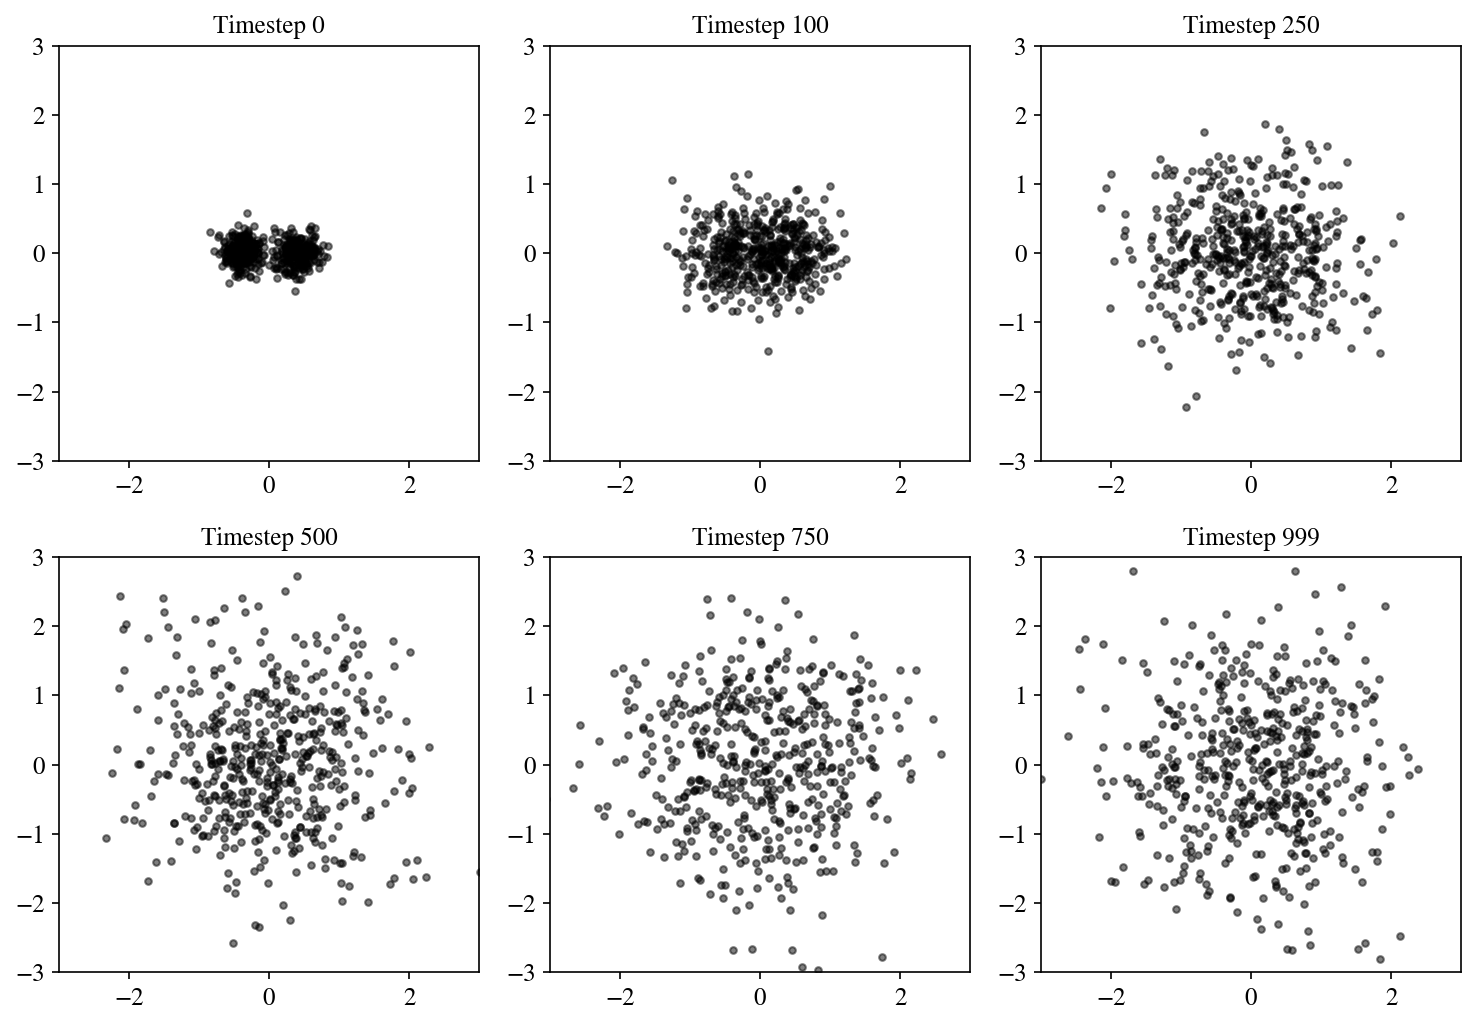

In [ ]:
# Convert data to torch tensor
x_0 = torch.from_numpy(data[:500]).to(device)  # Use subset for visualisation

# Visualize diffusion at different timesteps
timesteps_to_show = [0, 100, 250, 500, 750, 999]

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.flatten()

for idx, t in enumerate(timesteps_to_show):
    if t == 0:
        # Show original data
        noisy_data = x_0.cpu().numpy()
    else:
        # Apply forward diffusion
        t_tensor = torch.full((x_0.shape[0],), t, dtype=torch.long, device='cpu')
        noisy_data, _ = schedule.forward_diffusion(x_0, t_tensor)
        noisy_data = noisy_data.cpu().numpy()

    axes[idx].scatter(noisy_data[:, 0], noisy_data[:, 1], alpha=0.5, s=10, color='k')
    axes[idx].set_xlim(-3, 3)
    axes[idx].set_ylim(-3, 3)
    axes[idx].set_title(f'Timestep {t}', fontsize=12)
    # axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3: Define the Denoising Network

Now we need a neural network that can predict the noise $\varepsilon$ that was added at each timestep. The network takes as input:
- The noisy data $x_t$
- The timestep $t$ (we embed this to give the network temporal context)

And outputs a prediction of the noise $\hat{\varepsilon}$ that should be removed.

For this toy problem, we'll use a simple MLP with sinusoidal position embeddings for the timestep. In real applications like image generation, this would be a U-Net architecture, but the principle is the same.

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Embed the timestep using sinusoidal functions.

    This is similar to the positional encoding used in Transformers. It allows
    the network to understand which timestep it's denoising, which is essential
    because the optimal denoising operation depends on how noisy the input is.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleDenoiser(nn.Module):
    """
    A simple MLP that predicts the noise in x_t.

    The architecture:
    1. Embed the timestep using sinusoidal embeddings
    2. Concatenate the timestep embedding with the noisy input
    3. Pass through several fully connected layers with ReLU activations
    4. Output a noise prediction of the same dimension as the input
    """
    def __init__(self, data_dim=2, time_embed_dim=64, hidden_dim=128):
        super().__init__()

        # Timestep embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embed_dim),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.ReLU(),
        )

        # Main denoising network
        self.network = nn.Sequential(
            nn.Linear(data_dim + time_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim),
        )

    def forward(self, x, t):
        """
        Predict the noise in x_t.

        Args:
            x: Noisy data at timestep t, shape (batch_size, data_dim)
            t: Timestep, shape (batch_size,)

        Returns:
            Predicted noise, shape (batch_size, data_dim)
        """
        # Embed the timestep
        t_embed = self.time_mlp(t)

        # Concatenate noisy data with timestep embedding
        x_input = torch.cat([x, t_embed], dim=1)

        # Predict the noise
        return self.network(x_input)


# Create the model
model = SimpleDenoiser(data_dim=2, time_embed_dim=64, hidden_dim=128).to(device)

print("Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Model architecture:
SimpleDenoiser(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
  )
  (network): Sequential(
    (0): Linear(in_features=66, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

Total parameters: 46018


## Step 4: Training the Denoising Network

The training process is elegant in its simplicity:

1. Take a batch of real data $x_0$
2. Sample random timesteps $t$ for each data point
3. Add noise according to the forward process to get $x_t$
4. Ask the network to predict what noise was added
5. Compute the mean squared error between predicted and actual noise
6. Backpropagate and update weights

The loss function is simply:
$$L = \mathbb{E}_{t, x_0, \varepsilon} \left[ \| \varepsilon - \varepsilon_\theta(x_t, t) \|^2 \right]$$

where $\varepsilon_\theta$ is our neural network's noise prediction.

In [ ]:
def train_ddpm(model, data, schedule, num_epochs=100, batch_size=128, lr=1e-3):
    """
    Train the denoising network.
    """
    # Prepare data loader
    # Ensure data is float and move to tensor
    dataset = TensorDataset(torch.from_numpy(data).float())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    losses = []

    for epoch in tqdm(range(num_epochs), desc="Training the denoising network"):
        epoch_loss = 0
        num_batches = 0

        for batch in dataloader:
            x_0 = batch[0].to(device)
            batch_size_actual = x_0.shape[0]

            # Sample random timesteps for each data point in the batch
            # FIX: Use schedule.num_timesteps (correct attribute name)
            # and ensure t is on CPU for indexing the schedule parameters.
            t = torch.randint(0, schedule.num_timesteps, (batch_size_actual,), device='cpu')

            # Generate random noise (Correctly generated on the target device)
            noise = torch.randn_like(x_0)

            # Add noise to get x_t
            x_t, actual_noise = schedule.forward_diffusion(x_0, t, noise)

            # Predict the noise
            # Move the index tensor t back to the device for the model's forward pass
            predicted_noise = model(x_t, t.to(device))

            # Compute loss (mean squared error between predicted and actual noise)
            loss = nn.functional.mse_loss(predicted_noise, actual_noise)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

        # Display loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}")

    return losses


# Train the model
print("Training the denoising network...\n")
losses = train_ddpm(model, data, schedule, num_epochs=100, batch_size=128, lr=1e-3)

Training the denoising network...



Training the denoising network:  11%|█         | 11/100 [00:01<00:12,  6.88it/s]

Epoch 10/100, Loss: 0.121778


Training the denoising network:  21%|██        | 21/100 [00:03<00:10,  7.51it/s]

Epoch 20/100, Loss: 0.121002


Training the denoising network:  31%|███       | 31/100 [00:04<00:07,  8.74it/s]

Epoch 30/100, Loss: 0.105168


Training the denoising network:  41%|████      | 41/100 [00:05<00:06,  8.90it/s]

Epoch 40/100, Loss: 0.106931


Training the denoising network:  51%|█████     | 51/100 [00:06<00:05,  8.58it/s]

Epoch 50/100, Loss: 0.115824


Training the denoising network:  61%|██████    | 61/100 [00:07<00:04,  8.27it/s]

Epoch 60/100, Loss: 0.108357


Training the denoising network:  71%|███████   | 71/100 [00:08<00:03,  8.46it/s]

Epoch 70/100, Loss: 0.103449


Training the denoising network:  81%|████████  | 81/100 [00:09<00:02,  8.71it/s]

Epoch 80/100, Loss: 0.102273


Training the denoising network:  91%|█████████ | 91/100 [00:11<00:01,  8.74it/s]

Epoch 90/100, Loss: 0.101735


Training the denoising network: 100%|██████████| 100/100 [00:12<00:00,  8.21it/s]

Epoch 100/100, Loss: 0.104285


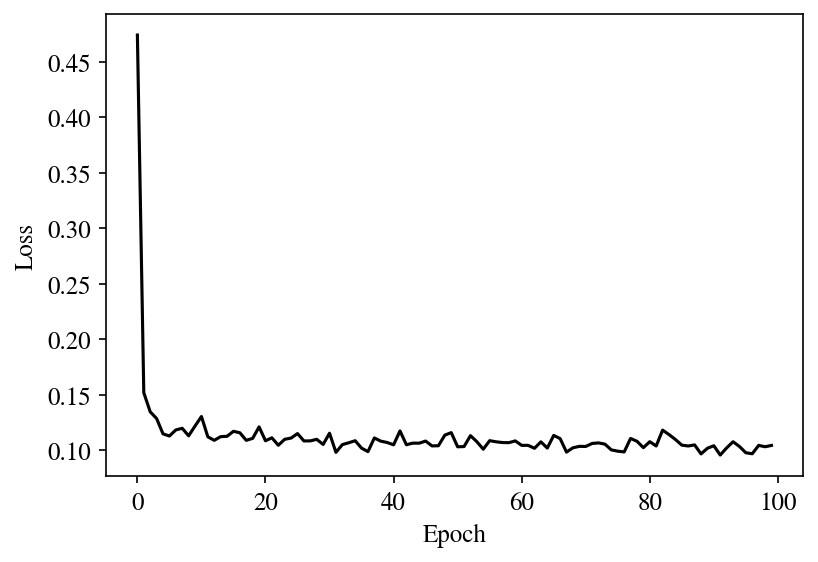


Training complete! Final loss: 0.104285


In [ ]:
# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(losses, color='k')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(f"\nTraining complete! Final loss: {losses[-1]:.6f}")

## Step 5: Sampling from the Learned Model

Now comes the exciting part - generating new samples! The sampling process reverses the forward diffusion:

1. Start with pure Gaussian noise $x_T$
2. For $t = T, T-1, \cdots, 1$:
   - Use the network to predict the noise in $x_t$
   - Remove (most of) that noise to get $x_{t-1}$
   - Add a small amount of new noise (except at the final step)
3. Return $x_0$ as our generated sample

The reverse process is:
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 I)$$

where $\mu_\theta$ is computed from our noise prediction.

In [ ]:
@torch.no_grad()
def sample_ddpm(model, schedule, num_samples=500, save_trajectory=False):
    """
    Generate samples by reversing the diffusion process.

    We start from pure noise and iteratively denoise using our trained network.

    Args:
        model: Trained denoising network
        schedule: DDPM noise schedule
        num_samples: Number of samples to generate
        save_trajectory: If True, save intermediate states for visualisation

    Returns:
        Generated samples (and optionally the full trajectory)
    """
    model.eval()

    # Start from pure Gaussian noise
    x_t = torch.randn(num_samples, 2, device=device)

    trajectory = [x_t.cpu().numpy()] if save_trajectory else None

    # Reverse diffusion process
    for t in tqdm(reversed(range(schedule.num_timesteps)), desc="Sampling"):
        # Create timestep tensor
        t_tensor = torch.full((num_samples,), t, dtype=torch.long, device=device)

        # Predict the noise
        predicted_noise = model(x_t, t_tensor)

        # Extract schedule parameters
        alpha_t = schedule.alphas[t]
        alpha_bar_t = schedule.alphas_cumprod[t]
        beta_t = schedule.betas[t]

        # Compute the mean of p(x_{t-1} | x_t)
        # This formula comes from the DDPM paper and involves removing the predicted noise
        # and scaling appropriately
        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / torch.sqrt(1.0 - alpha_bar_t)) * predicted_noise
        )

        if t > 0:
            # Add noise for all steps except the last one
            # The variance is \sigma_t^2 = \beta_t (we could also use other variance schedules)
            noise = torch.randn_like(x_t)
            sigma_t = torch.sqrt(beta_t)
            x_t = mean + sigma_t * noise
        else:
            # At the final step, don't add noise
            x_t = mean

        # Save trajectory for visualisation
        if save_trajectory and (t % 50 == 0 or t == 0):
            trajectory.append(x_t.cpu().numpy())

    if save_trajectory:
        return x_t.cpu().numpy(), trajectory
    else:
        return x_t.cpu().numpy()


# Generate samples
print("\nGenerating samples from pure noise...\n")
generated_samples, trajectory = sample_ddpm(model, schedule, num_samples=500, save_trajectory=True)

print(f"\nGenerated {generated_samples.shape[0]} samples!")


Generating samples from pure noise...



Sampling: 1000it [00:00, 1306.94it/s]


Generated 500 samples!


## Visualize the Reverse Process

Let's see how the samples gradually emerge from noise as we reverse the diffusion process. This is the magic of diffusion models - we're watching structure emerge from randomness through many small, learned denoising steps.

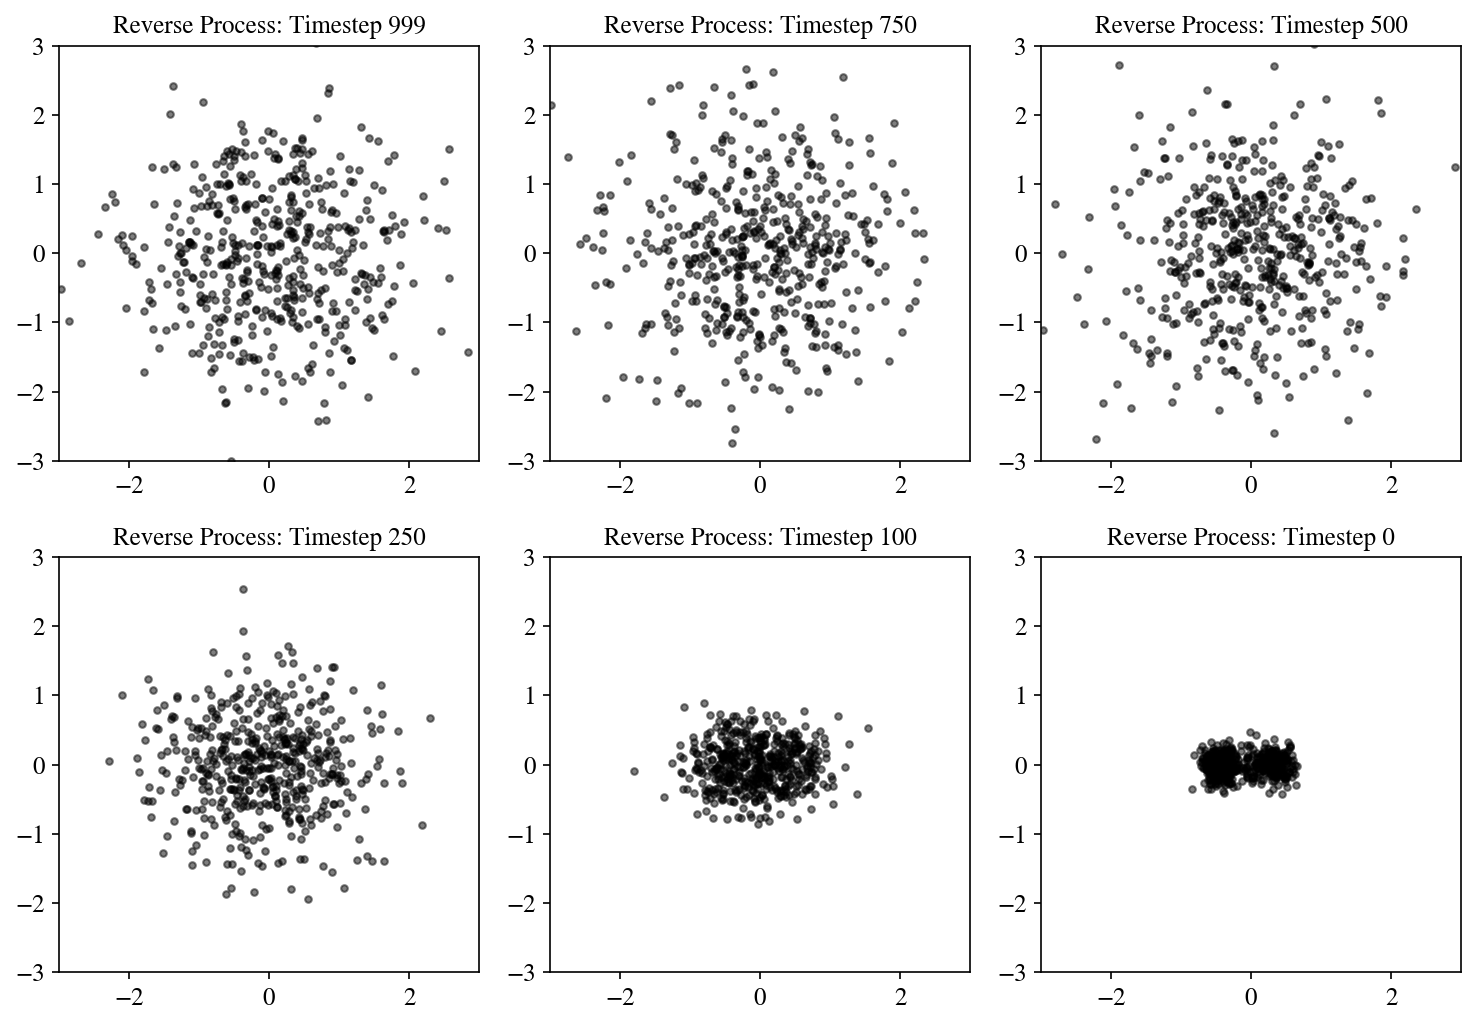

Notice how the samples start as pure noise and gradually coalesce into two clusters.
This is the learned reverse process recovering structure from randomness!


In [ ]:
# Show the reverse diffusion trajectory
timesteps_to_show = [999, 750, 500, 250, 100, 0]
indices_in_trajectory = [0, 5, 10, 15, 18, -1]  # Corresponding indices in saved trajectory

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.flatten()

for idx, (t, traj_idx) in enumerate(zip(timesteps_to_show, indices_in_trajectory)):
    samples_at_t = trajectory[traj_idx]

    axes[idx].scatter(samples_at_t[:, 0], samples_at_t[:, 1], alpha=0.5, s=10, color='k')
    axes[idx].set_xlim(-3, 3)
    axes[idx].set_ylim(-3, 3)
    axes[idx].set_title(f'Reverse Process: Timestep {t}', fontsize=12)

plt.tight_layout()
plt.show()

print("Notice how the samples start as pure noise and gradually coalesce into two clusters.")
print("This is the learned reverse process recovering structure from randomness!")

## Compare Generated Samples with Original Data

Let's put the generated samples side-by-side with our original data to see how well the model learned the distribution.

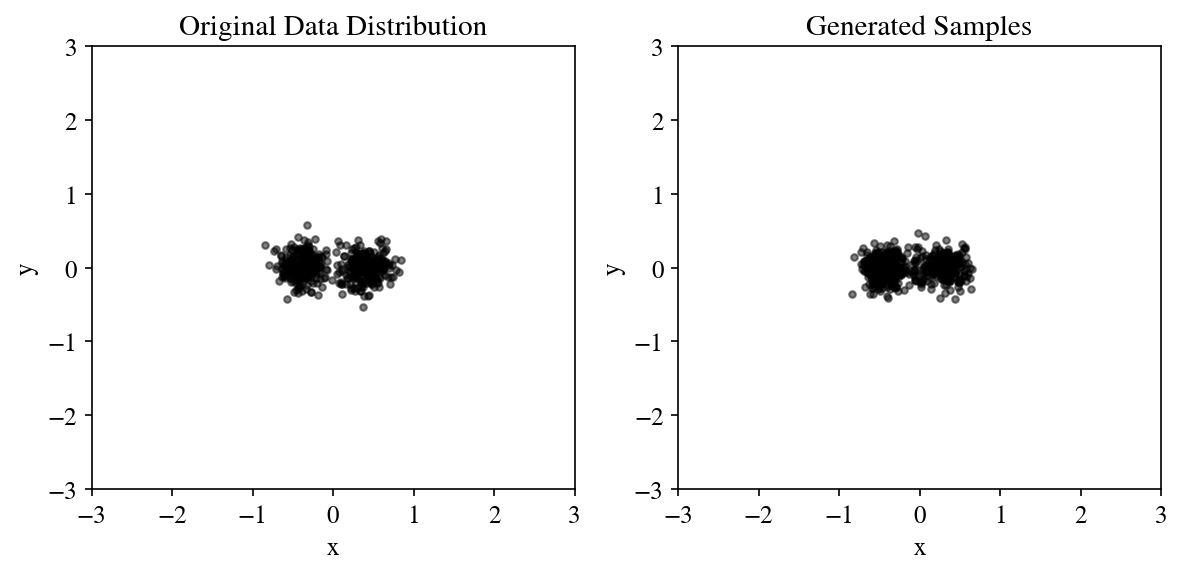

The generated samples should closely match the original data distribution.
Both should show two distinct clusters at roughly the same locations.


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Original data
axes[0].scatter(data[:500, 0], data[:500, 1], alpha=0.5, s=10, color='k')
axes[0].set_xlim(-3, 3)
axes[0].set_ylim(-3, 3)
axes[0].set_title('Original Data Distribution', fontsize=14)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Generated samples
axes[1].scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, s=10, color='k')
axes[1].set_xlim(-3, 3)
axes[1].set_ylim(-3, 3)
axes[1].set_title('Generated Samples', fontsize=14)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

plt.tight_layout()
plt.show()

print("The generated samples should closely match the original data distribution.")
print("Both should show two distinct clusters at roughly the same locations.")

## Key Takeaways

This notebook demonstrated the core principles of DDPM diffusion models:

**Forward Process**: We gradually add Gaussian noise over many timesteps until data becomes pure noise. This process is deterministic and requires no learning.

**Training**: We train a neural network to predict the noise that was added at each timestep. The loss is simply the mean squared error between predicted and actual noise.

**Sampling**: We start from pure noise and iteratively denoise using our trained network, reversing the forward process to generate new samples.

**Why It Works**: By breaking generation into many small steps, each denoising step is relatively easy to learn. The network only needs to make small corrections at each step, rather than learning to generate complex data from scratch.

For real applications like image generation, the same principles apply but with:
- U-Net architectures instead of simple MLPs
- Conditioning mechanisms (like cross-attention) for text-to-image generation
- More timesteps (typically 1000) and more sophisticated noise schedules
- Various sampling speedup techniques (DDIM, DPM-Solver, etc.)

The mathematics and training procedure remain fundamentally the same!